In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib
import scipy.signal

matplotlib.rcParams['mathtext.fontset']='cm'

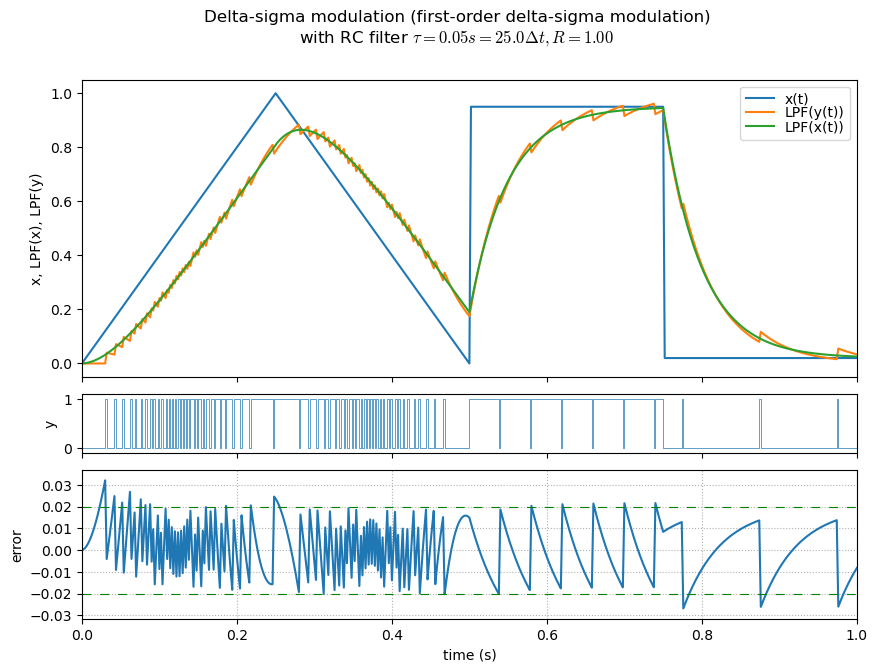

In [5]:
def dsmod1(x, A, R=1, modulate=True):
    """ first-order delta-sigma modulation """
    y = np.zeros_like(x)
    n = len(y)
    accum = 0
    out = 0
    M = 1 if modulate else 0
    for i in range(n):
        accum += R*(x[i] - out*A)
        out_q = 1 if accum >= R*A else 0
        out = (M*out_q
              +(1-M)*accum)
        y[i] = out
    return y
dsmod1.argformat = ''

def samplewave(T=1,dt=0.002):
    t = np.arange(0,T+1e-5,dt)
    x = 1-np.abs(4*t-1)
    x[4*t>2] = 0.95
    x[t>0.75] = 0.02
    return t,x

def describe_dsmod(dsmod, args):
    sdtype = dsmod.__doc__.splitlines()[0].strip()
    try:
        sdargfmt = dsmod.argformat
    except:
        sdargfmt = ''
    return sdtype + sdargfmt.format(*args)
    
def show_dsmod_samplewave(t,x,dsmod,args=(1,),tau=0.05, R=1, fig=None,
                          return_handles=False, filter_dsmod=False):
    dt = t[1]-t[0]
    if filter_dsmod:
        x1 = dsmod(x, *args,R=R, modulate=False)
    else:
        x1 = x
    y = dsmod(x,*args,R=R)
    a = dt/tau
    yfilt = scipy.signal.lfilter([a],[1,a-1],y)
    xfilt = scipy.signal.lfilter([a],[1,a-1],x1)

    if fig is None:
        fig = plt.figure(figsize=(10,7), facecolor='white')
    gs = gridspec.GridSpec(3, 1,height_ratios=[2,0.4,1])
    axes = [fig.add_subplot(gs[k]) for k in range(3)]
    ax0 = axes[0]
    ax0.plot(t,x,label='x(t)')
    ax0.plot(t,yfilt,label='LPF(y(t))')
    ax0.plot(t,xfilt,label='LPF(x(t))')
    ax0.legend(labelspacing=0,loc='upper right',fontsize=10)
    ax0.set_ylabel('x, LPF(x), LPF(y)')
    ax0.set_xticklabels([])

    ax1 = axes[1]
    ax1.step(t,y,linewidth=0.5)
    ax1.set_ylim([-0.1,1.1])
    ax1.set_yticks([0,1])
    ax1.set_ylabel('y')
    ax1.set_xticklabels([])

    ax2 = axes[2]
    filt_error = xfilt-yfilt
    ylim = (min(filt_error),max(filt_error))
    # plot margin
    s = 0.08
    ylim = (ylim[0]*(1+s)-ylim[1]*s, ylim[1]*(1+s)-ylim[0]*s)
    ax2.plot(t,filt_error)
    ax2.set_ylim(ylim)
    for s in [-1,1]:
        # approximate error bounds; we'll show why later in the article
        ax2.plot([t[0],t[-1]],[s*a/2,s*a/2],color='#008000',linewidth=0.8,dashes=[8,8])
    ax2.set_ylabel('error')
    ax2.get_yaxis().set_major_locator(ticker.MaxNLocator(12,steps=[1,2,5,10]))
    ax2.set_xlabel('time (s)')
    ax2.grid(True,linestyle=':')
    
    for ax in axes:
        ax.set_xlim(min(t),max(t))
    
    fig.subplots_adjust(hspace=0.1)
    fig.suptitle('Delta-sigma modulation (%s)\nwith RC filter $\\tau=%.2f s = %.1f\\Delta t, R=%.2f$'
                 % (describe_dsmod(dsmod,args), tau, tau/dt, R))
    if return_handles:
        return fig, (ax0,ax1,ax2)

t,x = samplewave()
show_dsmod_samplewave(t,x,dsmod1,filter_dsmod=True)

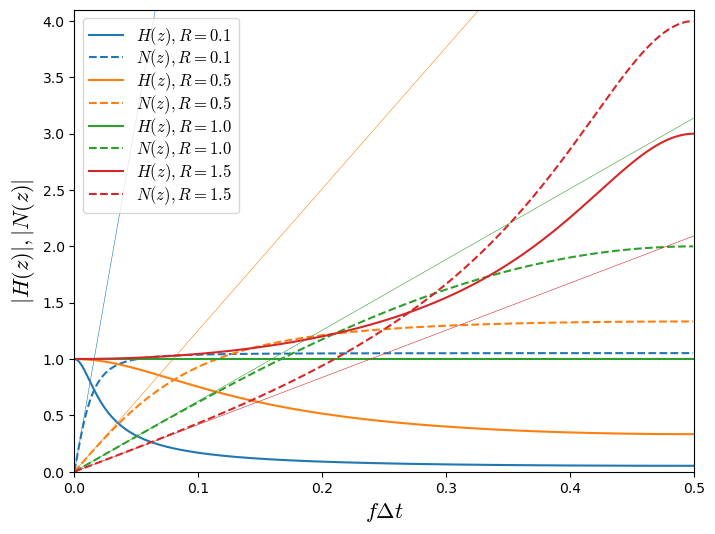

In [6]:
fig = plt.figure(figsize=(8,6), facecolor='white')
ax = fig.add_subplot(1,1,1)
f = np.arange(0,0.5,0.001)
# frequency, normalized to 1/delta T
for R in [0.1,0.5,1.0,1.5]:
    z = np.exp(2j*np.pi*f)
    zinv = 1/z
    H = R/(1+(R-1)*zinv)
    N = (1-zinv)/(1+(R-1)*zinv)
    line = ax.plot(f,np.abs(H), label='$H(z), R=%.1f$' % R)
    linecolor = line[0].get_color()
    ax.plot(f,np.abs(N),color=linecolor,linestyle='--',
            label='$N(z), R=%.1f$' % R)
    x0 = 0.5
    ax.plot([0,x0],[0,x0*(2*np.pi/R)],'-',color=linecolor,linewidth=0.4)
ax.legend(labelspacing=0, fontsize=12, loc='upper left')
ax.set_xlabel('$f\Delta t$', fontsize=16)
ax.set_xlim(0,0.5)
ax.set_ylabel('$|H(z)|, |N(z)|$', fontsize=16)
ax.set_ylim(0,4.1);